In [ ]:
# This file is based on:
# https://github.com/huggingface/diffusion-models-class/blob/main/unit1/02_diffusion_models_from_scratch.ipynb
# https://github.com/ewatson2/EEL6812_DeepFool_Project/blob/main/utils/project_utils.py

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
FOLDERNAME = 'Colab\ Notebooks/PROJECT'
%cd drive/MyDrive/$FOLDERNAME

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/PROJECT


In [ ]:
import torch
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print(device)

cuda


In [ ]:
import torchvision.transforms as T
import torchvision.datasets as dset
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
train = dset.MNIST('./train', True, transform=T.Compose([T.ToTensor(), T.RandomAutocontrast(), T.Resize((32, 32))]), download=True)
val = dset.MNIST('./val', False, transform=T.Compose([T.ToTensor(), T.RandomAutocontrast(), T.Resize((32, 32))]), download=True)

In [ ]:
train_dataloader = DataLoader(train, batch_size=8, shuffle=True)

Input shape: torch.Size([8, 1, 32, 32])
Labels: tensor([2, 1, 4, 0, 2, 3, 1, 8])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


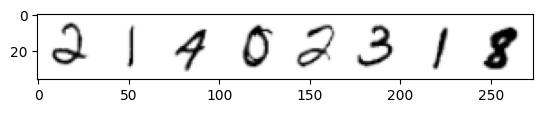

In [ ]:
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

In [ ]:
# def corrupt(x, amount):
#   noise = torch.rand_like(x)
#   amount = amount.reshape(-1, 1, 1, 1)
#   return x*(1-amount) + noise*amount

In [ ]:
# Try FGSM
from torch.autograd import Variable

# Build a simple model for FGSM
model = nn.Sequential(
    # N x 1 x 32 x 32
    nn.Conv2d(1, 64, 3, 1, 1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    # N x 64 x 16 x 16
    nn.Conv2d(64, 64, 3, 1, 1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    # N x 64 x 8 x 8
    nn.Flatten(),
    nn.Linear(in_features=64*8*8, out_features=10)
)

# Move model to GPU
model = model.cuda()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def fgsm(model, x, y, loss_function, eps, min=0, max=1):
  if not isinstance(x, Variable):
    x, y = Variable(x.to(device), requires_grad=True), Variable(y.to(device))
  x.requires_grad = True
  scores = model(x)
  loss = loss_function(scores, y)
  model.zero_grad()
  loss.backward(retain_graph=True)
  return Variable(torch.clamp(x.data + eps * torch.sign(x.grad.data), min=min, max=max))

In [ ]:
# Training Procedure
def trainningProcedure(num_epoch, model, mini_trains, device, loss_function, optimizer):
  for epoch in range(num_epoch):
    num_iters = 0
    for x, y in mini_trains:
      model.train()
      x = x.to(device)
      y = y.to(device)
      scores = model(x)
      loss = loss_function(scores, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      num_iters += 1

# Start training
trainningProcedure(1, model, train_dataloader, device, loss_function, optimizer)
model.eval()

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=4096, out_features=10, bias=True)
)

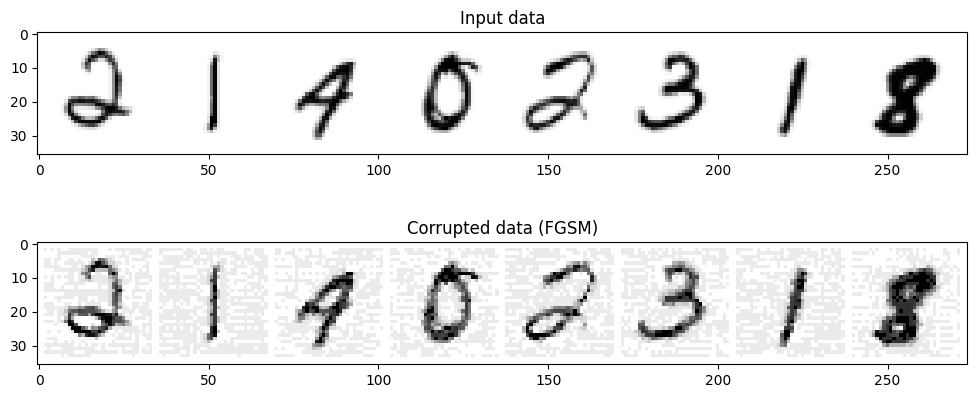

In [ ]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x.cpu())[0].numpy(), cmap='Greys')

# Adding noise
# x.shape => 8, 1, 32, 32
# amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
# noised_x = corrupt(x, amount)
eps = 0.15
x, y = Variable(x.to(device)), Variable(y.to(device))
x_adv = fgsm(model, x, y, loss_function, eps)
x_adv = x_adv.data
# x_adv.shape

# Plotting the noised version
axs[1].set_title('Corrupted data (FGSM)')
axs[1].imshow(torchvision.utils.make_grid(x_adv.cpu())[0].numpy(), cmap='Greys');

In [ ]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.double_conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
  def forward(self, x):
    return self.double_conv(x)


class UNet(nn.Module):
  def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
    super().__init__()
    self.ups = nn.ModuleList()
    self.downs = nn.ModuleList()

    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature))
      in_channels = feature

    for feature in reversed(features):
      self.ups.append(nn.ConvTranspose2d(feature*2, feature, 2, 2))
      self.ups.append(DoubleConv(feature*2, feature))

    self.bottleneck = DoubleConv(features[-1], features[-1]*2)
    self.final_conv = nn.Conv2d(features[0], out_channels, 1)

  def forward(self, x):
    skip_connections = []
    for down in self.downs:
      x = down(x) # 3 -> 64 -> 128 -> 256 -> 512
      skip_connections.append(x)
      x = F.max_pool2d(x, (2, 2))
    x = self.bottleneck(x)
    skip_connections.reverse()

    for i in range(0, len(self.ups), 2):
      x = self.ups[i](x)
      skip_connection = skip_connections[i//2]
      concat_x = torch.cat((skip_connection, x), dim=1)
      x = self.ups[i+1](concat_x)

    return self.final_conv(x)

In [ ]:
# net = UNet(in_channels=1)
# x = torch.rand(8, 1, 32, 32)
# print(net(x).shape)

In [ ]:
# sum([p.numel() for p in net.parameters()])

Finished epoch 0. Average loss for this epoch: 0.003218
Finished epoch 1. Average loss for this epoch: 0.003947
Finished epoch 2. Average loss for this epoch: 0.004571


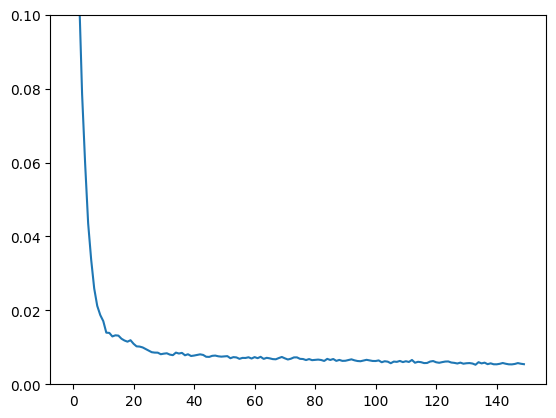

In [ ]:
# Dataloader (you can mess with batch size)
batch_size = 128
from itertools import islice
train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
partial_batches = list(islice(train_dataloader, 50))

# How many runs through the data should we do?
n_epochs = 3

net = UNet(in_channels=1)
net.to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters())

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in partial_batches:

        # Get some data and prepare the corrupted version
        # x = x.to(device) # Data on the GPU
        # noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        # noisy_x = corrupt(x, noise_amount) # Create our noisy x
        eps = 0.3
        x, y = Variable(x.to(device)), Variable(y.to(device))
        x_adv = fgsm(model, x, y, loss_function, eps)
        x_adv = x_adv.data

        # Get the model prediction
        pred = net(x_adv)

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1);

Original Image Acc: 98.438%
FGSM Image Acc: 16.406%
Unet Image Acc: 92.969%
Original Image: [1, 1, 7, 7, 3, 1, 4, 6]
FGSM Image: [8, 8, 8, 8, 8, 8, 8, 8]
UNet Image: [1, 1, 7, 7, 3, 1, 8, 6]
True Label: [1, 1, 7, 7, 3, 1, 4, 6]


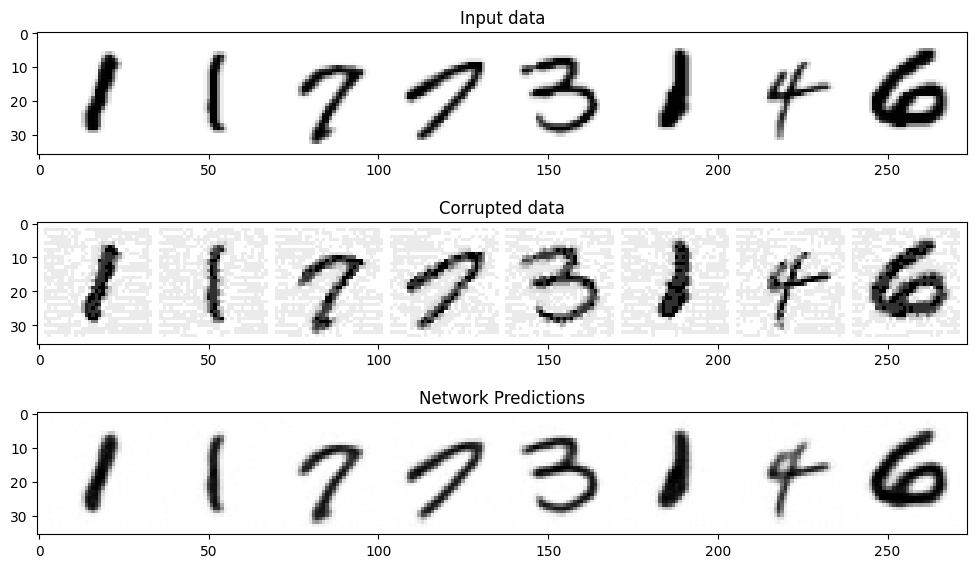

In [ ]:
# Fetch some data
x, y = next(iter(train_dataloader))
# x = x[:8] # Only using the first 8 for easy plotting
# y = y[:8]

# Corrupt with a range of amounts
# amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
# noised_x = corrupt(x, amount)
eps = 0.15
x, y = Variable(x.to(device)), Variable(y.to(device))
x_adv = fgsm(model, x, y, loss_function, eps)
x_adv = x_adv.data

# Get the model predictions
with torch.no_grad():
  preds = net(x_adv.to(device)).detach()

y_list = y.tolist()
count = len(y_list)
label_x = model(x)
pred_x = label_x.max(1)[1]
acc_orig = pred_x.eq(y).sum().item()
print(f"Original Image Acc: {acc_orig/count*100:.3f}%")
label_pert = model(x_adv)
pred_pert = label_pert.max(1)[1]
acc_pert = pred_pert.eq(y).sum().item()
print(f"FGSM Image Acc: {acc_pert/count*100:.3f}%")
label_preds = model(preds)
predictions = label_preds.max(1)[1]
acc_unet = predictions.eq(y).sum().item()
print(f"Unet Image Acc: {acc_unet/count*100:.3f}%")


import os
# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x[:8].cpu())[0].numpy().clip(0, 1), cmap='Greys')
print('Original Image:', pred_x[:8].tolist())
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(x_adv[:8].cpu())[0].numpy().clip(0, 1), cmap='Greys')
print('FGSM Image:', pred_pert[:8].tolist())
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds[:8].cpu())[0].clip(0, 1), cmap='Greys')
print('UNet Image:', predictions[:8].tolist())
# plt.savefig(os.path.join("./", "result_{}.png".format("FGSM")))
print('True Label:', y_list[:8])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Original Image Acc: 96.800%
FGSM Image Acc: 19.800%
Unet Image Acc: 93.400%


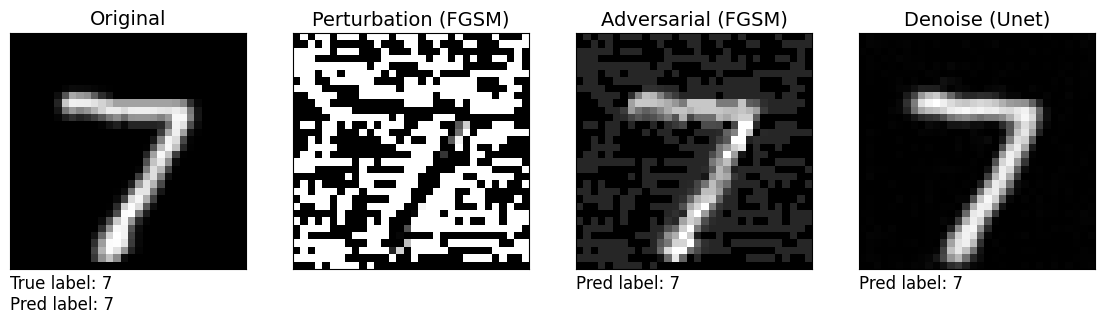

Original Image: [7, 2, 1, 0, 4, 1, 4, 9]
FGSM Image: [7, 2, 8, 0, 9, 8, 8, 8]
UNet Image: [7, 2, 1, 0, 4, 1, 4, 9]
True Label: [7, 2, 1, 0, 4, 1, 4, 9]


In [ ]:
# Fetch some data
val_dataloader = DataLoader(val, batch_size=1000, shuffle=False)
x, y = next(iter(val_dataloader))

# Get the model predictions
eps = 0.15
x, y = Variable(x.to(device)), Variable(y.to(device))
x_adv = fgsm(model, x, y, loss_function, eps)
# x_adv = x_adv.data

# Get the model predictions
with torch.no_grad():
  preds = net(x_adv.to(device)).detach()

y_list = y.tolist()
count = len(y_list)
label_x = model(x)
pred_x = label_x.max(1)[1]
acc_orig = pred_x.eq(y).sum().item()
print(f"Original Image Acc: {acc_orig/count*100:.3f}%")
label_pert = model(x_adv)
pred_pert = label_pert.max(1)[1]
acc_pert = pred_pert.eq(y).sum().item()
print(f"FGSM Image Acc: {acc_pert/count*100:.3f}%")
label_preds = model(preds)
predictions = label_preds.max(1)[1]
acc_unet = predictions.eq(y).sum().item()
print(f"Unet Image Acc: {acc_unet/count*100:.3f}%")

pertubation = x_adv - x

fig = plt.figure(figsize=(14, 10), facecolor='white')
fig.add_subplot(1, 4, 1)
plt.xticks([])
plt.yticks([])
plt.xlabel(f"True label: {y[0]}\nPred label: {pred_x[0]}", fontsize=12, loc='left')
plt.title(label='Original', fontsize=14)
plt.imshow(torchvision.utils.make_grid(x[0].cpu())[0].numpy().clip(0, 1), cmap='gray')
fig.add_subplot(1, 4, 2)
plt.xticks([])
plt.yticks([])
plt.title(label='Perturbation (FGSM)', fontsize=14)
plt.imshow(torchvision.utils.make_grid(pertubation[0].cpu())[0].numpy().clip(0, 1), cmap='gray')
fig.add_subplot(1, 4, 3)
plt.xticks([])
plt.yticks([])
plt.xlabel(f"Pred label: {pred_pert[0]}", fontsize=12, loc='left')
plt.title(label='Adversarial (FGSM)', fontsize=14)
plt.imshow(torchvision.utils.make_grid(x_adv[0].cpu())[0].numpy().clip(0, 1), cmap='gray')
fig.add_subplot(1, 4, 4)
plt.xticks([])
plt.yticks([])
plt.xlabel(f"Pred label: {predictions[0]}", fontsize=12, loc='left')
plt.title(label='Denoise (Unet)', fontsize=14)
plt.imshow(torchvision.utils.make_grid(preds[0].cpu())[0].clip(0, 1), cmap='gray')
plt.show()
print('Original Image:', pred_x[:8].tolist())
print('FGSM Image:', pred_pert[:8].tolist())
print('UNet Image:', predictions[:8].tolist())
print('True Label:', y_list[:8])

import os
fig.savefig(os.path.join("./", "result_{}.png".format("FGSM+Unet_val")))